### Load the libaries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

In [5]:
#plt.style.available

### Read the Data

In [6]:
# Getting Stock data using nsepy library
import pandas_datareader as web

StockData = web.DataReader(name='^NSEI',data_source='yahoo', start='2010-01-01')    #end='2020-08-09'
print(StockData.shape)
StockData.head()

(2702, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,5238.450195,5167.100098,5200.899902,5232.200195,0.0,5232.200195
2010-01-05,5288.350098,5242.399902,5277.149902,5277.899902,0.0,5277.899902
2010-01-06,5310.850098,5260.049805,5278.149902,5281.799805,0.0,5281.799805
2010-01-07,5302.549805,5244.750000,5281.799805,5263.100098,0.0,5263.100098
2010-01-08,5276.750000,5234.700195,5264.250000,5244.750000,0.0,5244.750000


In [7]:
StockData['TradeDate'] = StockData.index
StockData.tail()

,High,Low,Open,Close,Volume,Adj Close,TradeDate
Date,,,,,,,
2021-01-07,14256.250000,14123.099609,14253.750000,14137.349609,559200.0,14137.349609,2021-01-07
2021-01-08,14367.299805,14221.650391,14258.400391,14347.250000,613500.0,14347.250000,2021-01-08
2021-01-11,14498.200195,14383.099609,14474.049805,14484.750000,672900.0,14484.750000,2021-01-11
2021-01-12,14590.650391,14432.849609,14473.799805,14563.450195,929600.0,14563.450195,2021-01-12
2021-01-13,14653.349609,14435.700195,14639.799805,14564.849609,0.0,14564.849609,2021-01-13


## Plot the data

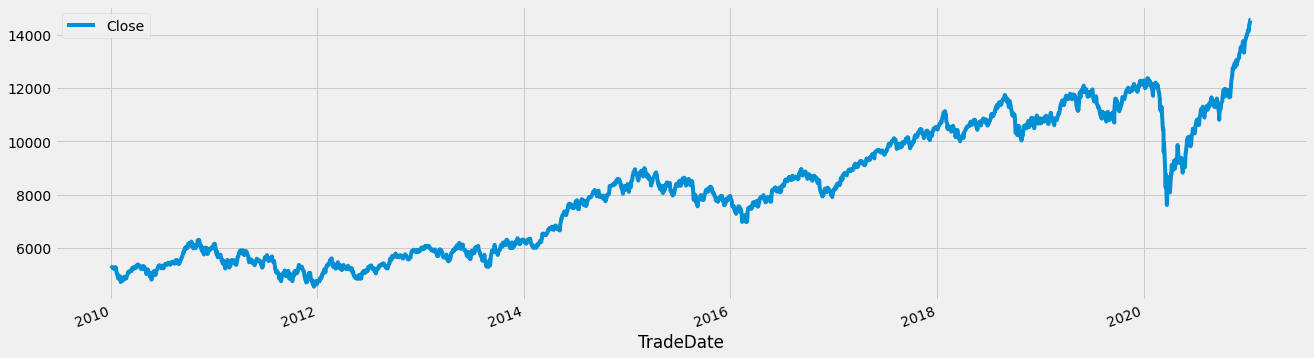

In [8]:
Y_VAR = "Close"
StockData.plot(x='TradeDate',y=Y_VAR,kind='line',figsize=(20,6),rot=20)

## Data Selection

In [9]:
FullData = StockData[[Y_VAR]].values

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#sc=StandardScaler()
sc=MinMaxScaler()

DataScalar = sc.fit(FullData)
X = DataScalar.transform(FullData)

X[0:5]

array([[0.06865822],
       [0.07321878],
       [0.07360796],
       [0.07174185],
       [0.06991062]])

## Define Timesteps

In [11]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=15  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [12]:
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
X_data.shape

(2687, 15, 1)

In [13]:
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
y_data.shape

(2687, 1)

In [14]:
# Choosing the number of testing data records
TestingRecords=TimeSteps

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

# Printing the shape of training and testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2672, 15, 1)
(2672, 1)
(15, 15, 1)
(15, 1)


In [15]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 15
Number of Features: 1


In [16]:
#regressor.add(Dense(units=15, kernel_initializer='normal', activation='relu'))


## Define Model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

regressor = Sequential()

#regressor.add(LSTM(units=30,activation='relu',kernel_initializer='glorot_uniform',input_shape = (TimeSteps,TotalFeatures),return_sequences=True))   #kernel_initializer='glorot_normal'
#regressor.add(Dropout(0.01))

#regressor.add(LSTM(units = 30,activation='relu',kernel_initializer='glorot_normal',input_shape = (TimeSteps,TotalFeatures)))
#regressor.add(Dropout(0.01))
regressor.add(LSTM(units = 30,activation='tanh',input_shape = (TimeSteps,TotalFeatures)))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam',loss='mean_squared_error')

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [18]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size=10, epochs = 100,verbose=0)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

############### Total Time Taken:  2 Minutes #############


## Perform Predictions

In [19]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScalar.inverse_transform(predicted_Price)
predicted_Price[TestingRecords-3:]


array([[14282.326],
       [14431.997],
       [14493.67 ]], dtype=float32)

In [20]:
# Getting the original price values for testing data
orig=y_test
orig=DataScalar.inverse_transform(y_test)
orig[TestingRecords-3:]

array([[14484.75      ],
       [14563.45019531],
       [14564.84960938]])

## Check Accuracy

In [21]:
# Accuracy of the predictions
100 - (100*(abs(orig-predicted_Price)/orig)).mean()

98.93530497520851

## Visualize the performance

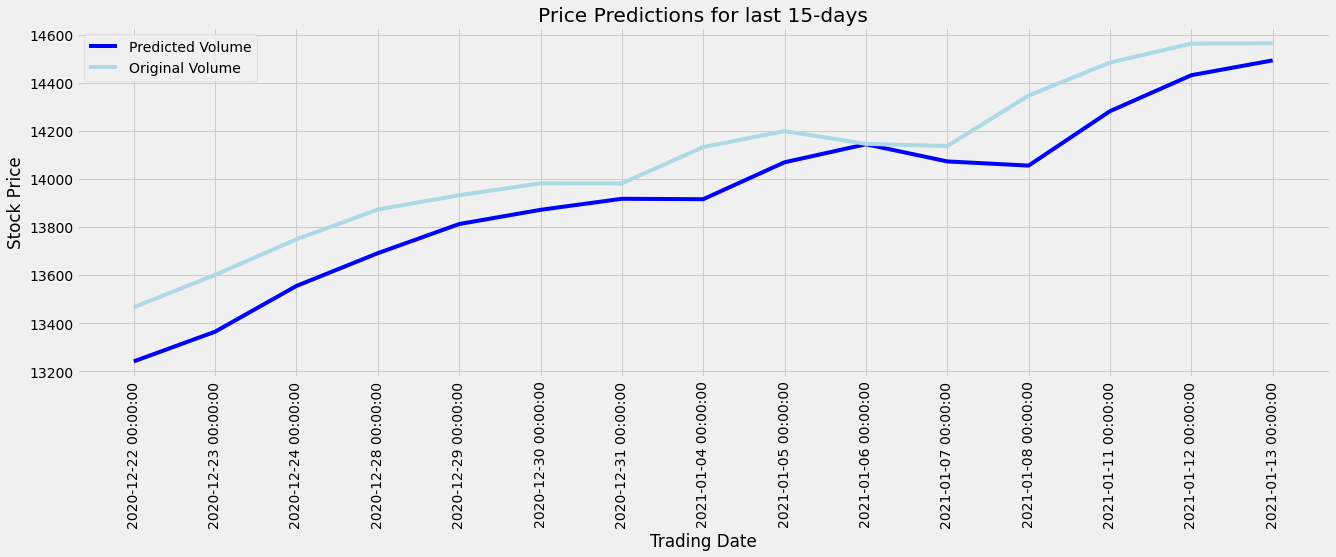

In [22]:
# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Price Predictions for last 15-days')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'],rotation=90)
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

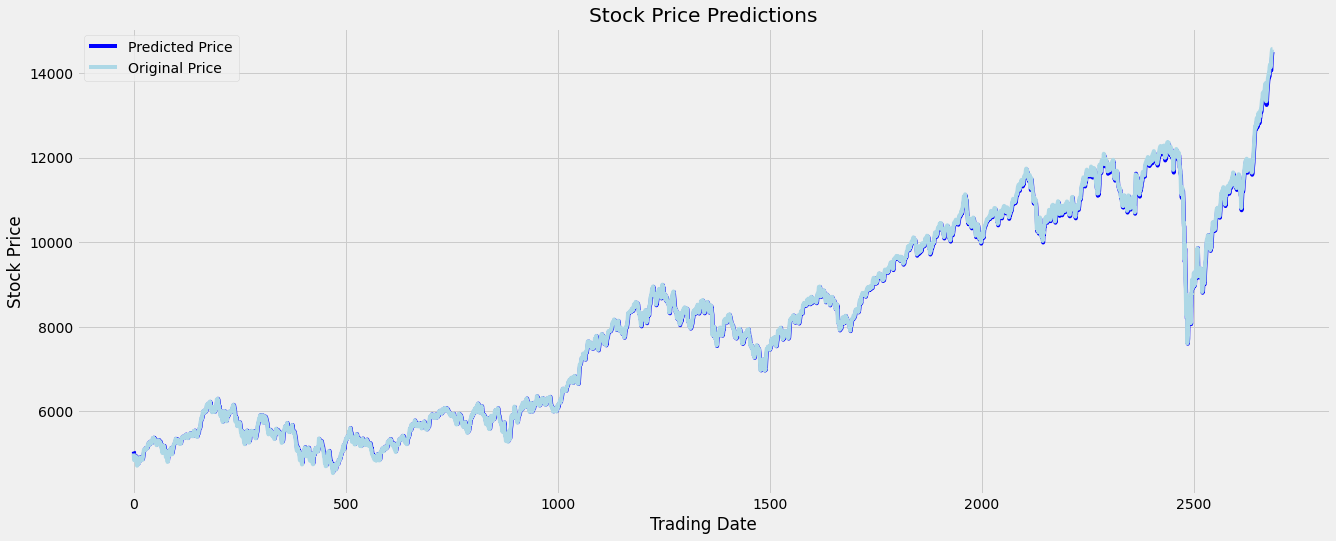

In [23]:
# Generating predictions on full data
TrainPredictions=DataScalar.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScalar.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## Predict Tomorrow

In [24]:
latest = X[-TimeSteps:]
X_test_new = np.reshape(latest,(1,latest.shape[0],1))
X_test_new.shape
pred_price_today = regressor.predict(X_test_new)
print("Today's Predicted Stock Price is:", DataScalar.inverse_transform(pred_price_today))

Today's Predicted Stock Price is: [[14487.092]]
